Optimal input: DEX-DEX

Optimal input for DEX-DEX arbitrage: 176.5331
Max profit for DEX-DEX arbitrage: 72.373455
Best delta_y = 177.0000
Profit at this delta_y = 72.373097


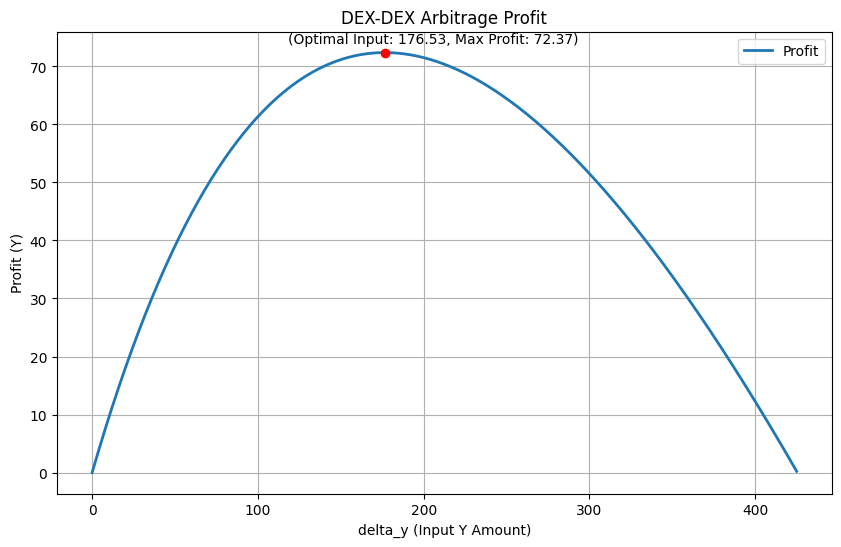

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def dex_out_with_fee(delta_in, L_in, L_out, fee):
    """
    Uniswap V2 style swap with a fee fraction 'fee' on the input:
    out = (L_out * (x_in * (1-fee))) / (L_in + (x_in * (1-fee)))
    """
    effective_in = delta_in * (1 - fee)
    return (L_out * effective_in) / (L_in + effective_in)

def round_trip_profit(delta_y, a1, b1, a2, b2, fee1, fee2):
    """
    Given an input delta_y of token Y for the first swap:
      - Swap in Pool 1 (reserves (a1,b1)) to get token X
      - Swap all that X in Pool 2 (reserves (a2,b2)) back to token Y
    Returns the net profit (final Y - initial delta_y).
    """
    # 1. Pool 1: Y -> X
    x_out = dex_out_with_fee(delta_y, b1, a1, fee1)
    
    # 2. Pool 2: X -> Y
    y_out = dex_out_with_fee(x_out, a2, b2, fee2)
    
    # 3. Profit in Y
    profit = y_out - delta_y
    return profit

def simulate_dex_dex_arb(a1, b1, a2, b2, fee1=0.003, fee2=0.003, 
                         y_min=0.0, y_max=1000.0, steps=1001):
    """
    Brute-force simulation over a range of delta_y from y_min to y_max,
    returning (delta_y, profit) for each step.

    a1, b1 = reserves for Pool 1 (X, Y)
    a2, b2 = reserves for Pool 2 (X, Y)
    fee1, fee2 = fractional fees on each trade
    """
    delta_ys = np.linspace(y_min, y_max, steps)
    results = []

    for y_val in delta_ys:
        p = round_trip_profit(y_val, a1, b1, a2, b2, fee1, fee2)
        results.append((y_val, p))
    
    return np.array(results)

if __name__ == "__main__":
    # Example usage:
    # Reserves for two pools and fees:
    dex1_x, dex1_y = 2000.0, 1000.0   # Pool 1 reserves (X_reserve, Y_reserve)
    dex2_x, dex2_y = 1500.0, 1500.0   # Pool 2 reserves (X_reserve, Y_reserve)
    dex1_fee = 0.003            # 0.3% fee in Pool 1
    dex2_fee = 0.003            # 0.3% fee in Pool 2

    # Simulate over a range of delta_y values
    results = simulate_dex_dex_arb(dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee, 
                                   y_min=0, y_max=2000, steps=2001)
    
    # Only consider positive profits
    results = results[results[:, 1] >= 0]
    
    # Find the best delta_y (max profit)
    best_index = np.argmax(results[:, 1])
    best_delta_y = results[best_index, 0]
    best_profit  = results[best_index, 1]

    # Numerically compute max profit for dex-dex
    # Using the implementation from https://github.com/gabrielfu/amm-arbitrage/blob/master/src/model.ts
    # y = expensive in dex1
    denominator = (dex2_x + dex1_x * (1 - dex1_fee))
    y = (dex1_y * dex2_x) / denominator
    y_ = (dex2_y * dex1_x * (1 - dex1_fee)) / denominator
    optimal_dex_input = ((np.sqrt(y * y_ * (1 - dex1_fee))) - y) / (1 - dex1_fee)
    max_dex_profit = round_trip_profit(optimal_dex_input, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee)
    print(f"Optimal input for DEX-DEX arbitrage: {optimal_dex_input:.4f}")
    print(f"Max profit for DEX-DEX arbitrage: {max_dex_profit:.6f}")

    print(f"Best delta_y = {best_delta_y:.4f}")
    print(f"Profit at this delta_y = {best_profit:.6f}")

    # Plot the profit amount versus delta_y
    plt.figure(figsize=(10, 6))
    plt.plot(results[:, 0], results[:, 1], label="Profit", lw=2)
    
    # Scatter point for the best delta_y (optimal input)
    plt.scatter(optimal_dex_input, max_dex_profit, color='red', zorder=3)

    # Annotate the scatter point
    plt.annotate(f"(Optimal Input: {optimal_dex_input:.2f}, Max Profit: {max_dex_profit:.2f})", 
                (optimal_dex_input, max_dex_profit), 
                textcoords="offset points", xytext=(-70,7), ha='left', color='black')

    plt.xlabel("delta_y (Input Y Amount)")
    plt.ylabel("Profit (Y)")
    plt.title("DEX-DEX Arbitrage Profit")
    plt.legend()
    plt.grid(True)
    plt.show()


Optimal input: DEX-DEX vs CEX-DEX

Optimal input for DEX-DEX arbitrage: 176.5331
Max profit for DEX-DEX arbitrage: 72.373455
Optimal input for CEX-DEX arbitrage: 412.6223
Max profit for CEX-DEX arbitrage: 169.746386
DEX-DEX Arbitrage:
Best delta_y = 177.0000, Profit = 72.373097
CEX-DEX Arbitrage:
Best delta_y = 413.0000, Profit = 169.746285


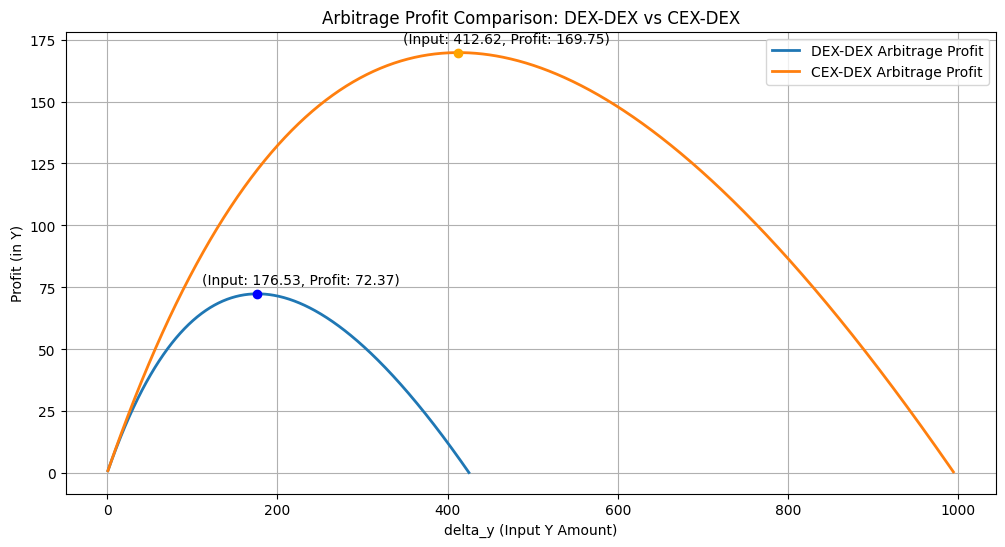

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def dex_out_with_fee(x_in, L_in, L_out, fee):
    """
    Performs a swap on a constant-product DEX with fee.
    Uses the formula:
        effective_in = x_in * (1 - fee)
        out = (L_out * effective_in) / (L_in + effective_in)
    """
    effective_in = x_in * (1 - fee)
    return (L_out * effective_in) / (L_in + effective_in)

def round_trip_profit_dex_dex(delta_y, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee):
    """
    Simulate DEX-DEX arbitrage:
      1. Swap token Y for token X on DEX 1.
      2. Swap the obtained token X for token Y on DEX 2.
    Returns the net profit in token Y.
    """
    # 1. DEX 1: Y -> X
    x_out = dex_out_with_fee(delta_y, dex1_y, dex1_x, dex1_fee)
    # 2. DEX 2: X -> Y
    y_out = dex_out_with_fee(x_out, dex2_x, dex2_y, dex2_fee)
    return y_out - delta_y

def simulate_dex_dex_arb(dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee, y_min, y_max, steps):
    """
    Simulate DEX-DEX arbitrage for a range of input Y amounts (delta_y).
    Returns arrays for delta_y and corresponding profit values.
    """
    delta_ys = np.linspace(y_min, y_max, steps)
    profits = np.array([round_trip_profit_dex_dex(dy, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee) 
                        for dy in delta_ys])
    return delta_ys, profits

def round_trip_profit_cex_dex(delta_y, dex1_x, dex1_y, dex1_fee, cex_price, cex_fee):
    """
    Simulate CEX-DEX arbitrage:
      1. Swap token Y for token X on DEX 1.
      2. Sell token X on the CEX at the given price (X in terms of Y) and after paying the CEX fee.
    Returns the net profit in token Y.
    """
    # DEX 1 swap: Y -> X
    x_out = dex_out_with_fee(delta_y, dex1_y, dex1_x, dex1_fee)
    # CEX sale: Sell X for Y at given price and after CEX fee
    y_cex = x_out * cex_price * (1 - cex_fee)
    return y_cex - delta_y

def simulate_cex_dex_arb(dex1_x, dex1_y, dex1_fee, cex_price, cex_fee, y_min, y_max, steps):
    """
    Simulate CEX-DEX arbitrage for a range of input Y amounts (delta_y).
    Returns arrays for delta_y and corresponding profit values.
    """
    delta_ys = np.linspace(y_min, y_max, steps)
    profits = np.array([round_trip_profit_cex_dex(dy, dex1_x, dex1_y, dex1_fee, cex_price, cex_fee)
                        for dy in delta_ys])
    return delta_ys, profits

def simulate_arbitrage(dex1_x, dex1_y, dex1_fee, dex2_x, dex2_y, dex2_fee,
                       cex_price, cex_fee, y_min=0, y_max=2000, steps=2001):
    """
    Given DEX and CEX parameters, simulate both DEX-DEX and CEX-DEX arbitrage strategies.
    Returns a tuple:
        ( (delta_ys_dex, profits_dex_dex), (delta_ys_cex, profits_cex_dex) )
    """
    # DEX-DEX arbitrage simulation
    delta_ys_dex, profits_dex_dex = simulate_dex_dex_arb(dex1_x, dex1_y, dex2_x, dex2_y, 
                                                          dex1_fee, dex2_fee, y_min, y_max, steps)
    # CEX-DEX arbitrage simulation
    delta_ys_cex, profits_cex_dex = simulate_cex_dex_arb(dex1_x, dex1_y, dex1_fee, 
                                                          cex_price, cex_fee, y_min, y_max, steps)
    return (delta_ys_dex, profits_dex_dex), (delta_ys_cex, profits_cex_dex)

if __name__ == "__main__":
    # Example parameters:
    # DEX 1 parameters: liquidity (X, Y) and fee (for Y -> X swap)
    dex1_x = 2000.0
    dex1_y = 1000.0
    dex1_fee = 0.003  # 0.3% fee

    # DEX 2 parameters: liquidity (X, Y) and fee (for X -> Y swap)
    dex2_x = 1500.0
    dex2_y = 1500.0
    dex2_fee = 0.003  # 0.3% fee

    # CEX parameters: price of X in terms of Y and fee
    cex_price = 1 
    cex_fee = 0.001   # 0.1% fee on CEX

    # Simulation range for delta_y (the initial amount of token Y)
    y_min = 0
    y_max = 2000
    steps = 2001

    # Run the simulation
    (delta_dex, profits_dex_dex), (delta_cex, profits_cex_dex) = simulate_arbitrage(
        dex1_x, dex1_y, dex1_fee, dex2_x, dex2_y, dex2_fee, cex_price, cex_fee,
        y_min, y_max, steps
    )

    # Find the best delta_y for each strategy (only considering non-negative profits)
    best_idx_dex = np.argmax(profits_dex_dex)
    best_delta_dex = delta_dex[best_idx_dex]
    best_profit_dex = profits_dex_dex[best_idx_dex]

    best_idx_cex = np.argmax(profits_cex_dex)
    best_delta_cex = delta_cex[best_idx_cex]
    best_profit_cex = profits_cex_dex[best_idx_cex]

    # Numerically compute max profit for dex-dex
    # Using the implementation from https://github.com/gabrielfu/amm-arbitrage/blob/master/src/model.ts
    # y = expensive in dex1
    denominator = (dex2_x + dex1_x * (1 - dex1_fee))
    y = (dex1_y * dex2_x) / denominator
    y_ = (dex2_y * dex1_x * (1 - dex1_fee)) / denominator
    optimal_dex_input = ((np.sqrt(y * y_ * (1 - dex1_fee))) - y) / (1 - dex1_fee)
    max_dex_profit = round_trip_profit_dex_dex(optimal_dex_input, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee)
    print(f"Optimal input for DEX-DEX arbitrage: {optimal_dex_input:.4f}")
    print(f"Max profit for DEX-DEX arbitrage: {max_dex_profit:.6f}")

    # Numerically compute max profit for cex-dex
    optimal_cex_input = (np.sqrt(dex1_x * dex1_y * cex_price * (1 - dex1_fee) * (1 - cex_fee)) - dex1_y) / (1 - dex1_fee)
    max_cex_profit = round_trip_profit_cex_dex(optimal_cex_input, dex1_x, dex1_y, dex1_fee, cex_price, cex_fee)
    print(f"Optimal input for CEX-DEX arbitrage: {optimal_cex_input:.4f}")
    print(f"Max profit for CEX-DEX arbitrage: {max_cex_profit:.6f}")


    print("DEX-DEX Arbitrage:")
    print(f"Best delta_y = {best_delta_dex:.4f}, Profit = {best_profit_dex:.6f}")

    print("CEX-DEX Arbitrage:")
    print(f"Best delta_y = {best_delta_cex:.4f}, Profit = {best_profit_cex:.6f}")

    # # Plot both arbitrage profit curves in the same figure
    # plt.figure(figsize=(12, 6))
    # plt.plot(delta_dex, profits_dex_dex, label="DEX-DEX Arbitrage Profit", lw=2)
    # plt.plot(delta_cex, profits_cex_dex, label="CEX-DEX Arbitrage Profit", lw=2)
    # plt.xlabel("delta_y (Input Y Amount)")
    # plt.ylabel("Profit (in Y)")

    # Filter positive profit values for DEX-DEX
    positive_dex_mask = np.array(profits_dex_dex) > 0
    delta_dex_positive = np.array(delta_dex)[positive_dex_mask]
    profits_dex_dex_positive = np.array(profits_dex_dex)[positive_dex_mask]

    # Filter positive profit values for CEX-DEX
    positive_cex_mask = np.array(profits_cex_dex) > 0
    delta_cex_positive = np.array(delta_cex)[positive_cex_mask]
    profits_cex_dex_positive = np.array(profits_cex_dex)[positive_cex_mask]

    # Plot the filtered profits
    plt.figure(figsize=(12, 6))
    plt.plot(delta_dex_positive, profits_dex_dex_positive, label="DEX-DEX Arbitrage Profit", lw=2)
    plt.plot(delta_cex_positive, profits_cex_dex_positive, label="CEX-DEX Arbitrage Profit", lw=2)

    # Labels and legend
    plt.xlabel("delta_y (Input Y Amount)")
    plt.ylabel("Profit (in Y)")

    # Scatter point and annotation for DEX
    plt.scatter(optimal_dex_input, max_dex_profit, color='blue', zorder=3)
    plt.annotate(f"(Input: {optimal_dex_input:.2f}, Profit: {max_dex_profit:.2f})", 
                (optimal_dex_input, max_dex_profit), 
                textcoords="offset points", xytext=(-40,7), ha='left', color='black')

    # Scatter point and annotation for CEX
    plt.scatter(optimal_cex_input, max_cex_profit, color='orange', zorder=3)
    plt.annotate(f"(Input: {optimal_cex_input:.2f}, Profit: {max_cex_profit:.2f})", 
                (optimal_cex_input, max_cex_profit), 
                textcoords="offset points", xytext=(-40,7), ha='left', color='black')


    plt.title("Arbitrage Profit Comparison: DEX-DEX vs CEX-DEX")
    plt.legend()
    plt.grid(True)
    plt.show()


Profit vs Price Diff: DEX-DEX vs CEX-DEX

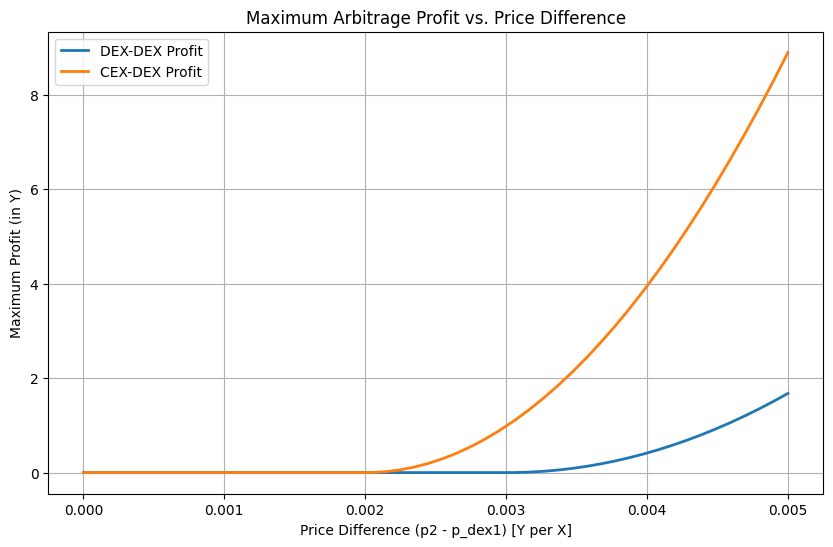

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def dex_out_with_fee(x_in, L_in, L_out, fee):
    """
    Performs a swap on a constant-product DEX with fee.
    effective_in = x_in * (1 - fee)
    out = (L_out * effective_in) / (L_in + effective_in)
    """
    effective_in = x_in * (1 - fee)
    return (L_out * effective_in) / (L_in + effective_in)

def round_trip_profit_dex_dex(delta_y, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee):
    """
    DEX-DEX arbitrage:
      1. Swap token Y for token X on DEX1.
      2. Swap the obtained token X for token Y on DEX2.
    Returns net profit (in Y).
    """
    # DEX1: Y -> X
    x_out = dex_out_with_fee(delta_y, dex1_y, dex1_x, dex1_fee)
    # DEX2: X -> Y
    y_out = dex_out_with_fee(x_out, dex2_x, dex2_y, dex2_fee)
    return y_out - delta_y

def round_trip_profit_cex_dex(delta_y, dex1_x, dex1_y, dex1_fee, cex_price, cex_fee):
    """
    CEX-DEX arbitrage:
      1. Swap token Y for token X on DEX1.
      2. Sell token X on the CEX at price cex_price (after paying cex_fee).
    Returns net profit (in Y).
    """
    # DEX1: Y -> X
    x_out = dex_out_with_fee(delta_y, dex1_y, dex1_x, dex1_fee)
    # Sell X on CEX: X -> Y at given price (with fee)
    y_cex = x_out * cex_price * (1 - cex_fee)
    return y_cex - delta_y

def optimal_profit(func, *args, y_min=0, y_max=2000):
    """
    Given a profit function (func) that depends on delta_y plus extra parameters,
    find the delta_y in [y_min, y_max] that maximizes profit.
    We use a scalar optimizer (minimize_scalar on the negative profit).
    Returns (opt_delta_y, max_profit) where max_profit is forced to be non-negative.
    """
    # We want to maximize profit so we minimize the negative of the profit function.
    res = minimize_scalar(lambda dy: -func(dy, *args),
                          bounds=(y_min, y_max), method='bounded')
    # Because of numerical issues, ensure non-negative profit:
    opt_profit = max(-res.fun, 0)
    return res.x, opt_profit

if __name__ == "__main__":
    # Fixed DEX1 parameters (this determines the DEX1 price)
    dex1_x = 2*10**6
    dex1_y = 10**6
    dex1_fee = 0.003  # 0.3% fee
    p_dex1 = dex1_y / dex1_x  # DEX1 implied price

    # For dex-dex arbitrage, we use DEX2 parameters.
    # We will vary DEX2's price by fixing dex2_x and setting dex2_y = dex2_x * p2.
    dex2_x = 1.5*10**6
    dex2_fee = 0.003  # 0.3% fee

    # For CEX-dex arbitrage, the CEX price will be set equal to p2 and its fee is:
    cex_fee = 0.001   # 0.1% fee

    # Define the range for p2 (the price on DEX2 and CEX).
    # We consider p2 values around p_dex1. The price difference is (p2 - p_dex1)
    p2_values = np.linspace(p_dex1, p_dex1 * 1.01, 50)
    price_diff = p2_values - p_dex1

    max_profits_dex_dex = []
    max_profits_cex_dex = []

    # We set a search range for delta_y. This may be adjusted depending on your liquidity.
    y_min = 0
    y_max = 2*10**6

    for p2 in p2_values:
        # Set DEX2 Y reserve from its price: dex2_y = dex2_x * p2
        dex2_y = dex2_x * p2

        # Optimal profit for dex-dex arbitrage:
        # Using the implementation from https://github.com/gabrielfu/amm-arbitrage/blob/master/src/model.ts
        # y = expensive in dex1
        denominator = (dex2_x + dex1_x * (1 - dex1_fee))
        y = (dex1_y * dex2_x) / denominator
        y_ = (dex2_y * dex1_x * (1 - dex1_fee)) / denominator
        opt_dex_input = ((np.sqrt(y * y_ * (1 - dex1_fee))) - y) / (1 - dex1_fee)
        # Ensure non-negative input amount
        dex_input = max(opt_dex_input, 0)
        max_profit_dex = round_trip_profit_dex_dex(dex_input, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee)
        # print(f"Optimal input for DEX-DEX arbitrage: {optimal_dex_input:.4f}")
        # print(f"Max profit for DEX-DEX arbitrage: {max_dex_profit:.6f}")
        
        # _, opt_profit_dex = optimal_profit(round_trip_profit_dex_dex,
        #                                    dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee,
        #                                    y_min=y_min, y_max=y_max)
        max_profits_dex_dex.append(max_profit_dex)

        # For cex-dex arbitrage, use the same DEX1 and set CEX price = p2.
        opt_cex_input = (np.sqrt(dex1_x * dex1_y * p2 * (1 - dex1_fee) * (1 - cex_fee)) - dex1_y) / (1 - dex1_fee)
        # Ensure non-negative input amount
        cex_input = max(opt_cex_input, 0)
        max_profit_cex = round_trip_profit_cex_dex(cex_input, dex1_x, dex1_y, dex1_fee, p2, cex_fee)
        # print(f"Optimal input for CEX-DEX arbitrage: {optimal_input:.4f}")
        # print(f"Optimal profit for CEX-DEX arbitrage: {optimal_profit:.6f}")


        # _, opt_profit_cex = optimal_profit(round_trip_profit_cex_dex,
        #                                    dex1_x, dex1_y, dex1_fee, p2, cex_fee,
        #                                    y_min=y_min, y_max=y_max)
        max_profits_cex_dex.append(max_profit_cex)

    max_profits_dex_dex = np.array(max_profits_dex_dex)
    max_profits_cex_dex = np.array(max_profits_cex_dex)

    # Plot maximum profit vs. price difference (p2 - p_dex1)
    plt.figure(figsize=(10, 6))
    plt.plot(price_diff, max_profits_dex_dex, label="DEX-DEX Profit", lw=2)
    plt.plot(price_diff, max_profits_cex_dex, label="CEX-DEX Profit", lw=2)
    plt.xlabel("Price Difference (p2 - p_dex1) [Y per X]")
    plt.ylabel("Maximum Profit (in Y)")
    plt.title("Maximum Arbitrage Profit vs. Price Difference")
    plt.legend()
    plt.grid(True)
    plt.show()


Profit vs Price Diff: DEX-DEX vs CEX-DEX vs Bridge DEX-DEX

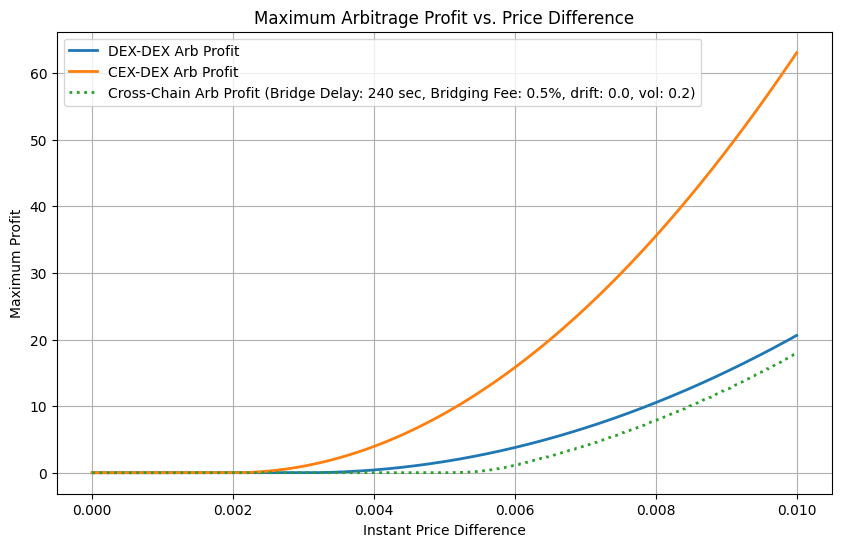

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def dex_out_with_fee(x_in, L_in, L_out, fee):
    """ Simulates a swap on a constant-product DEX with fee. """
    effective_in = x_in * (1 - fee)
    return (L_out * effective_in) / (L_in + effective_in)

def round_trip_profit_dex_dex(delta_y, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee):
    """ DEX-DEX arbitrage: Swap on DEX1, then swap back on DEX2. """
    x_out = dex_out_with_fee(delta_y, dex1_y, dex1_x, dex1_fee)
    y_out = dex_out_with_fee(x_out, dex2_x, dex2_y, dex2_fee)
    return y_out - delta_y

def round_trip_profit_cex_dex(delta_y, dex1_x, dex1_y, dex1_fee, cex_price, cex_fee):
    """ CEX-DEX arbitrage: Swap on DEX1, then sell on CEX. """
    x_out = dex_out_with_fee(delta_y, dex1_y, dex1_x, dex1_fee)
    y_cex = x_out * cex_price * (1 - cex_fee)  # Sell on CEX
    return y_cex - delta_y

# def round_trip_profit_bridge_dex_mc(delta_y, dex1_x, dex1_y, dex1_fee, dex2_x, dex2_y, dex2_fee, bridging_fee, T_sec):
#     """
#     Bridge-DEX arbitrage using Monte Carlo GBM for 240s bridging delay.
#     """
#     # Step 1: Swap token Y for token X on DEX1
#     x_out = dex_out_with_fee(delta_y, dex1_y, dex1_x, dex1_fee)

#     # Step 2: Apply bridging fee
#     x_after_bridge = x_out * (1 - bridging_fee)

#     # Step 3: Simulate GBM price paths for p2 after T_sec
#     M = 1000  # Monte Carlo simulations
#     dt = T_sec  # Time step in seconds
#     W_T = np.random.normal(0, np.sqrt(dt), M)  # Brownian motion at T_sec
#     p2_simulated = (dex2_y / dex2_x) * np.exp((mu - 0.5 * sigma**2) * dt + sigma * W_T)  # Simulated DEX2 price

#     # Step 4: Compute profit using dex_out_with_fee
#     y_out_simulated = np.array([
#         dex_out_with_fee(x_after_bridge, dex2_x, dex2_x * p_sim, dex2_fee)
#         for p_sim in p2_simulated
#     ])

#     # Step 5: Compute expected profit
#     expected_profit = np.mean(y_out_simulated - delta_y)

#     return expected_profit

def optimal_profit(func, *args, y_min=0, y_max=2*10**6):
    """ Finds the optimal delta_y that maximizes profit for an arbitrage function. """
    res = minimize_scalar(lambda dy: -func(dy, *args), bounds=(y_min, y_max), method='bounded')
    opt_profit = max(-res.fun, 0)
    return res.x, opt_profit

# Helper function to compute optimal input for dex-dex cross-chain arb considering bridging fee and delay (Monte Carlo)
def helper (p_sim_gbm, dex1_x, dex1_y, dex1_fee, dex2_x, dex2_fee, bridging_fee):
    dex2_y_simulated = dex2_x * p_sim_gbm

    denominator = (dex2_x + dex1_x * (1 - dex1_fee) * (1 - bridging_fee))
    y = (dex1_y * dex2_x) / denominator
    y_ = (dex2_y_simulated * dex1_x * (1 - dex1_fee) * (1 - bridging_fee)) / denominator
    opt_bridge_dex_input = ((np.sqrt(y * y_ * (1 - dex1_fee))) - y) / (1 - dex1_fee)
    # Ensure non-negative input amount
    bridge_dex_input = max(opt_bridge_dex_input, 0)
    profit = round_trip_profit_dex_dex(bridge_dex_input, dex1_x, dex1_y, dex2_x, dex2_y_simulated, dex1_fee, dex2_fee)
    return profit

# Initialize parameters
dex1_x = 2 * 10**6
dex1_y = 10**6
dex1_fee = 0.003  # 0.3% fee
p_dex1 = dex1_y / dex1_x  # DEX1 implied price

dex2_x = 1.5 * 10**6
dex2_fee = 0.003  # 0.3% fee

cex_fee = 0.001  # 0.1% fee
bridging_fee = 0.005  # 0.5% bridging fee
T_sec = 240  # Bridging duration in seconds (4 minutes)
# ETH-USD market parameters (converted to per-second scale)
mu_annual = 0.0
sigma_annual = 0.2
seconds_per_year = 365 * 24 * 60 * 60

mu = mu_annual / seconds_per_year  # Per-second drift
sigma = sigma_annual / np.sqrt(seconds_per_year)  # Per-second volatility

y_min_val = 0
y_max_val = 2 * 10**6

# Define a range for p2 (destination price on DEX2 or CEX)
p2_values = np.linspace(p_dex1, p_dex1 * 1.02, 500)
price_diff = p2_values - p_dex1

# Store results for all arbitrage strategies
max_profits_dex_dex = []
max_profits_cex_dex = []
max_profits_bridge_dex_mc = []


for p2 in p2_values:
    # Adjust DEX2 liquidity based on p2
    dex2_y = dex2_x * p2

    # Optimal profit for dex-dex arbitrage:
    # Using the implementation from https://github.com/gabrielfu/amm-arbitrage/blob/master/src/model.ts
    # y = expensive in dex1
    denominator = (dex2_x + dex1_x * (1 - dex1_fee))
    y = (dex1_y * dex2_x) / denominator
    y_ = (dex2_y * dex1_x * (1 - dex1_fee)) / denominator
    opt_dex_input = ((np.sqrt(y * y_ * (1 - dex1_fee))) - y) / (1 - dex1_fee)
    # Ensure non-negative input amount
    dex_input = max(opt_dex_input, 0)
    max_profit_dex = round_trip_profit_dex_dex(dex_input, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee)
    max_profits_dex_dex.append(max_profit_dex)

    # For cex-dex arbitrage, use the same DEX1 and set CEX price = p2.
    opt_cex_input = (np.sqrt(dex1_x * dex1_y * p2 * (1 - dex1_fee) * (1 - cex_fee)) - dex1_y) / (1 - dex1_fee)
    # Ensure non-negative input amount
    cex_input = max(opt_cex_input, 0)
    max_profit_cex = round_trip_profit_cex_dex(cex_input, dex1_x, dex1_y, dex1_fee, p2, cex_fee)
    max_profits_cex_dex.append(max_profit_cex)

    # Optimal profit for Bridge-DEX arbitrage with Monte Carlo GBM
    # Simulate GBM price paths for p2 after T_sec
    M = 1000  # Monte Carlo simulations
    dt = T_sec  # Time step in seconds
    W_T = np.random.normal(0, np.sqrt(dt), M)  # Brownian motion at T_sec
    p2_simulated = (dex2_y / dex2_x) * np.exp((mu - 0.5 * sigma**2) * dt + sigma * W_T)  # Simulated DEX2 price

    profits = np.array([
        helper(p_sim, dex1_x, dex1_y, dex1_fee, dex2_x, dex2_fee, bridging_fee)
        for p_sim in p2_simulated
    ])
 
    # Step 5: Compute expected profit
    bridge_dex_expected_profit = np.mean(profits)

    max_profits_bridge_dex_mc.append(bridge_dex_expected_profit)

# Convert results to numpy arrays
max_profits_dex_dex = np.array(max_profits_dex_dex)
max_profits_cex_dex = np.array(max_profits_cex_dex)
max_profits_bridge_dex_mc = np.array(max_profits_bridge_dex_mc)

# Create the main plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(price_diff, max_profits_dex_dex, label="DEX-DEX Arb Profit", lw=2)
ax.plot(price_diff, max_profits_cex_dex, label="CEX-DEX Arb Profit", lw=2)
ax.plot(price_diff, max_profits_bridge_dex_mc, label=f"Cross-Chain Arb Profit (Bridge Delay: {T_sec} sec, Bridging Fee: {bridging_fee*100}%, drift: {mu_annual}, vol: {sigma_annual})", lw=2, linestyle="dotted")

ax.set_xlabel("Instant Price Difference")
ax.set_ylabel("Maximum Profit")
ax.set_title(f"Maximum Arbitrage Profit vs. Price Difference")
ax.legend()
ax.grid(True)

# # Create an inset plot
# ax_inset = fig.add_axes([0.2, 0.4, 0.25, 0.25])  # [left, bottom, width, height]
# mask = (price_diff >= 0) & (price_diff <= 0.01)  # Select data for the inset
# ax_inset.plot(price_diff[mask], max_profits_dex_dex[mask], lw=1.5)
# ax_inset.plot(price_diff[mask], max_profits_cex_dex[mask], lw=1.5)
# ax_inset.plot(price_diff[mask], max_profits_bridge_dex_mc[mask], lw=1.5, linestyle="dotted")
# ax_inset.set_title("Zoomed In (0 - 0.01)")
# # ax_inset.set_xticks([])
# # ax_inset.set_yticks([])
# ax_inset.grid(True)

plt.show()


Profit Diff vs Bridge Duration and Bridge Fee: DEX-DEX vs Bridge DEX-DEX

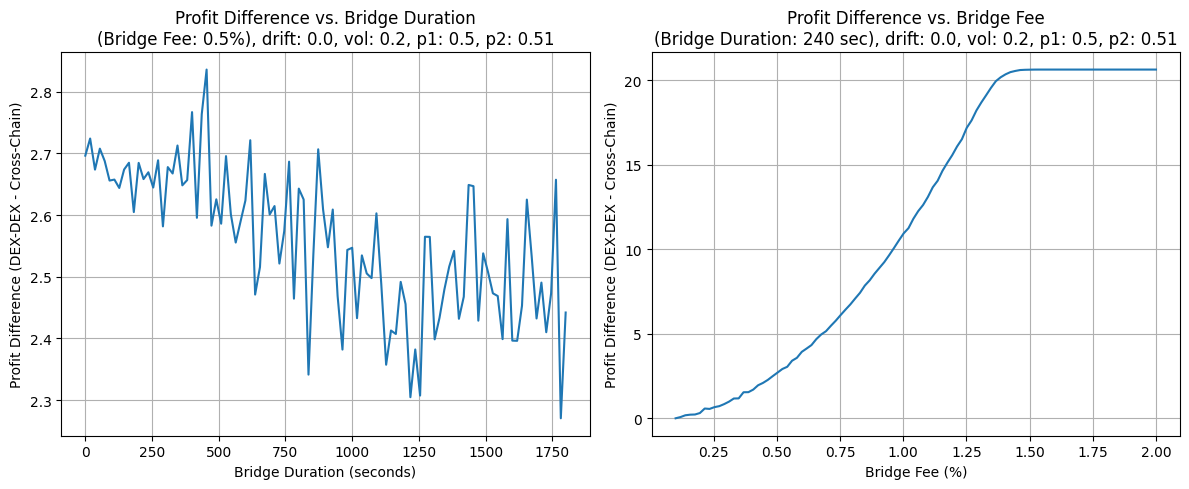

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def dex_out_with_fee(x_in, L_in, L_out, fee):
    """ Simulates a swap on a constant-product DEX with fee. """
    effective_in = x_in * (1 - fee)
    return (L_out * effective_in) / (L_in + effective_in)

def round_trip_profit_dex_dex(delta_y, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee):
    """ DEX-DEX arbitrage: Swap on DEX1, then swap back on DEX2. """
    x_out = dex_out_with_fee(delta_y, dex1_y, dex1_x, dex1_fee)
    y_out = dex_out_with_fee(x_out, dex2_x, dex2_y, dex2_fee)
    return y_out - delta_y

def round_trip_profit_bridge_dex_mc(delta_y, dex1_x, dex1_y, dex1_fee, dex2_x, dex2_y, dex2_fee, bridging_fee, T_sec):
    """
    Bridge-DEX arbitrage using Monte Carlo GBM.
    """
    # Swap token Y for token X on DEX1
    x_out = dex_out_with_fee(delta_y, dex1_y, dex1_x, dex1_fee)
    x_after_bridge = x_out * (1 - bridging_fee)  # Apply bridging fee

    # Simulate GBM price paths for p2 after T_sec
    M = 1000
    dt = T_sec
    W_T = np.random.normal(0, np.sqrt(dt), M)  # Brownian motion at T_sec
    p2_simulated = (dex2_y / dex2_x) * np.exp((mu - 0.5 * sigma**2) * dt + sigma * W_T)

    # Compute profit using dex_out_with_fee
    y_out_simulated = np.array([
        dex_out_with_fee(x_after_bridge, dex2_x, dex2_x * p_sim, dex2_fee)
        for p_sim in p2_simulated
    ])
    
    return np.mean(y_out_simulated - delta_y)

def optimal_profit(func, *args, y_min=0, y_max=2*10**6):
    """ Finds the optimal delta_y that maximizes profit for an arbitrage function. """
    res = minimize_scalar(lambda dy: -func(dy, *args), bounds=(y_min, y_max), method='bounded')
    return res.x, max(-res.fun, 0)

# Helper function to compute optimal input for dex-dex cross-chain arb considering bridging fee and delay (Monte Carlo)
def helper (p_sim_gbm, dex1_x, dex1_y, dex1_fee, dex2_x, dex2_fee, bridging_fee):
    dex2_y_simulated = dex2_x * p_sim_gbm

    denominator = (dex2_x + dex1_x * (1 - dex1_fee) * (1 - bridging_fee))
    y = (dex1_y * dex2_x) / denominator
    y_ = (dex2_y_simulated * dex1_x * (1 - dex1_fee) * (1 - bridging_fee)) / denominator
    opt_bridge_dex_input = ((np.sqrt(y * y_ * (1 - dex1_fee))) - y) / (1 - dex1_fee)
    # Ensure non-negative input amount
    bridge_dex_input = max(opt_bridge_dex_input, 0)
    profit = round_trip_profit_dex_dex(bridge_dex_input, dex1_x, dex1_y, dex2_x, dex2_y_simulated, dex1_fee, dex2_fee)
    return profit

# Initialize parameters
dex1_x, dex1_y = 2 * 10**6, 10**6
dex1_fee = 0.003
p_dex1 = dex1_y / dex1_x

dex2_x = 1.5 * 10**6
dex2_fee = 0.003

static_bridge_fee = 0.005
static_T_sec = 240
bridging_fees = np.linspace(0.001, 0.02, 100)  # Varying bridge fees
bridge_durations = np.linspace(0, 1800, 100)  # Varying bridge durations

# ETH-USD market parameters
mu_annual = 0.0
sigma_annual = 0.2
seconds_per_year = 365 * 24 * 60 * 60

mu = mu_annual / seconds_per_year
sigma = sigma_annual / np.sqrt(seconds_per_year)

y_min_val, y_max_val = 0, 2 * 10**6
p2 = p_dex1 * 1.02  # Small price difference for comparison
dex2_y = dex2_x * p2  # Adjust liquidity

# Compute profit difference vs. bridge duration
profit_diffs_duration = []
for T_sec in bridge_durations:
    # Optimal profit for dex-dex arbitrage:
    # Using the implementation from https://github.com/gabrielfu/amm-arbitrage/blob/master/src/model.ts
    # y = expensive in dex1
    denominator = (dex2_x + dex1_x * (1 - dex1_fee))
    y = (dex1_y * dex2_x) / denominator
    y_ = (dex2_y * dex1_x * (1 - dex1_fee)) / denominator
    opt_dex_input = ((np.sqrt(y * y_ * (1 - dex1_fee))) - y) / (1 - dex1_fee)
    # Ensure non-negative input amount
    dex_input = max(opt_dex_input, 0)
    max_profit_dex = round_trip_profit_dex_dex(dex_input, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee)

    # Optimal profit for Bridge-DEX arbitrage with Monte Carlo GBM
    # Simulate GBM price paths for p2 after T_sec
    M = 1000  # Monte Carlo simulations
    dt = T_sec  # Time step in seconds
    W_T = np.random.normal(0, np.sqrt(dt), M)  # Brownian motion at T_sec
    p2_simulated = (dex2_y / dex2_x) * np.exp((mu - 0.5 * sigma**2) * dt + sigma * W_T)  # Simulated DEX2 price

    profits = np.array([
        helper(p_sim, dex1_x, dex1_y, dex1_fee, dex2_x, dex2_fee, static_bridge_fee)
        for p_sim in p2_simulated
    ])

    bridge_dex_expected_profit = np.mean(profits)
 
    # _, opt_profit_dex = optimal_profit(round_trip_profit_dex_dex, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee)
    # _, opt_profit_bridge = optimal_profit(round_trip_profit_bridge_dex_mc, dex1_x, dex1_y, dex1_fee, dex2_x, dex2_y, dex2_fee, 0.00, T_sec)
    profit_diffs_duration.append(max_profit_dex - bridge_dex_expected_profit)

# Compute profit difference vs. bridge fee
profit_diffs_fee = []
for bridging_fee in bridging_fees:
    # Optimal profit for dex-dex arbitrage:
    # Using the implementation from https://github.com/gabrielfu/amm-arbitrage/blob/master/src/model.ts
    # y = expensive in dex1
    denominator = (dex2_x + dex1_x * (1 - dex1_fee))
    y = (dex1_y * dex2_x) / denominator
    y_ = (dex2_y * dex1_x * (1 - dex1_fee)) / denominator
    opt_dex_input = ((np.sqrt(y * y_ * (1 - dex1_fee))) - y) / (1 - dex1_fee)
    # Ensure non-negative input amount
    dex_input = max(opt_dex_input, 0)
    max_profit_dex = round_trip_profit_dex_dex(dex_input, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee)

    # Optimal profit for Bridge-DEX arbitrage with Monte Carlo GBM
    # Simulate GBM price paths for p2 after T_sec
    M = 1000  # Monte Carlo simulations
    dt = static_T_sec  # Time step in seconds
    W_T = np.random.normal(0, np.sqrt(dt), M)  # Brownian motion at T_sec
    p2_simulated = (dex2_y / dex2_x) * np.exp((mu - 0.5 * sigma**2) * dt + sigma * W_T)  # Simulated DEX2 price

    profits = np.array([
        helper(p_sim, dex1_x, dex1_y, dex1_fee, dex2_x, dex2_fee, bridging_fee)
        for p_sim in p2_simulated
    ])

    bridge_dex_expected_profit = np.mean(profits)

    # _, opt_profit_dex = optimal_profit(round_trip_profit_dex_dex, dex1_x, dex1_y, dex2_x, dex2_y, dex1_fee, dex2_fee)
    # _, opt_profit_bridge = optimal_profit(round_trip_profit_bridge_dex_mc, dex1_x, dex1_y, dex1_fee, dex2_x, dex2_y, dex2_fee, bridging_fee, 240)
    profit_diffs_fee.append(max_profit_dex - bridge_dex_expected_profit)

# --- Create the figure with two subplots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left subplot: Profit Difference vs. Bridge Duration
axes[0].plot(bridge_durations, profit_diffs_duration, linestyle='-')
axes[0].set_xlabel("Bridge Duration (seconds)")
axes[0].set_ylabel("Profit Difference (DEX-DEX - Cross-Chain)")
axes[0].set_title(f"Profit Difference vs. Bridge Duration\n(Bridge Fee: {static_bridge_fee*100}%), drift: {mu_annual}, vol: {sigma_annual}, p1: {p_dex1}, p2: {p2}")
axes[0].grid(True)

# Right subplot: Profit Difference vs. Bridge Fee
axes[1].plot(bridging_fees * 100, profit_diffs_fee, linestyle='-')
axes[1].set_xlabel("Bridge Fee (%)")
axes[1].set_ylabel("Profit Difference (DEX-DEX - Cross-Chain)")
axes[1].set_title(f"Profit Difference vs. Bridge Fee\n(Bridge Duration: {static_T_sec} sec), drift: {mu_annual}, vol: {sigma_annual}, p1: {p_dex1}, p2: {p2}")
axes[1].grid(True)

# Adjust layout for better spacing and display the plots
plt.tight_layout()
plt.show()